In [1]:
"""
A simple work-through example to model the Large Magellanic Cloud (LMC) as a perturbation to the Milky Way potential
"""

'\nA simple work-through example to model the Large Magellanic Cloud (LMC) as a perturbation to the Milky Way potential\n'

In [ ]:
import galax.potential as gp
import jax.numpy as jnp
import jax.random as jr
import optax
import matplotlib.pyplot as plt

from galactoPINNs.data import generate_static_datadict, scale_data, generate_xy_plane_grid
from galactoPINNs.models.static_model import StaticModel
from galactoPINNs.train import train_step_static, initialize_staged_optimizers, alternate_training
from galactoPINNs.model_potential import make_galax_potential
from galactoPINNs.layers import TrainableGalaxPotential

In [3]:
####
### Generate synthetic data for training and testing
####

true_MW_potential = gp.MilkyWayPotential()
true_lmc_potential = gp.NFWPotential(m=1.0e11, r_s=5.0, units="galactic")
lmc_center = jnp.array([50.0, 0.0, 0.0])  # in kpc
lmc_pot_centered = gp.TranslatedPotential(true_lmc_potential, translation=lmc_center)

true_potential = true_MW_potential + lmc_pot_centered
analytic_baseline_potential =  gp.NFWPotential(m= 5.4e11, r_s= 15.62, units="galactic")


In [ ]:
####
### Generate the training and testing sets
####

raw_datadict = generate_static_datadict(
    galax_potential=true_potential,
    N_samples_train = 2048,
    N_samples_test = 4096,
    r_max_train = 100, #kpc
    r_max_test = 150,  #kpc
)

In [ ]:
####
### Initialize a trainable analytic baseline model
####

trainable_params = ("m, r_s") # parameters of the baseline NFWPotential to be optimized

trainable_analytic_baseline = TrainableGalaxPotential(PotClass=gp.NFWPotential,
                                                        init_kwargs={"m": 5.4e11, "r_s": 15.62},
                                                        trainable=trainable_params)


In [6]:
####
### Nondimensionalize the data, and set up the model configuration
####

r_s = 15.62
include_analytic_baseline = True

scale_config = {
    "r_s": r_s,
    "include_analytic": True,
    "ab_potential": analytic_baseline_potential
}

# nondimensionalize the data
scaled_data, transformers = scale_data(
    raw_datadict, scale_config
)

# configure the desired model features
train_config = {
    "x_transformer": transformers["x"],
    "a_transformer": transformers["a"],
    "u_transformer": transformers["u"],
    "r_s": r_s,
    "ab_potential": analytic_baseline_potential,
    "include_analytic": True,
    "scale": gp.NFWPotential(m=5.4e11, r_s=15.62, units="galactic"),
    "depth": 6,
    "scale_reciprocal": False,
    "trainable": True   #setting trainable = False will use the fixed analytic baseline only
}

x_train = scaled_data["x_train"]
a_train = scaled_data["a_train"]


In [ ]:
####
### Initialize the model, optimizers, and hyperparameters
####

l_rel = 0.5     # weight for the relative loss term
lr0 = 2e-3      # initial learning rate

net = StaticModel(train_config, trainable_analytic_layer=trainable_analytic_baseline)
rng    = jr.PRNGKey(0)
init_params = net.init(rng, x_train[:1])["params"]

# Set up the staged optimizers
tx1, tx2 = initialize_staged_optimizers(net, optax.adam(lr0), x_train)

In [8]:
####
### Train the model with alternate training between the analytic-focused and NN-focused stages.
### Should converge in < 2 min; for optimal results, train for longer.
####

train_output = alternate_training(train_step_static,
    x_train, a_train, net,
    num_epochs_stage1=2000, num_epochs_stage2= 3000, cycles=1,
    param_list=trainable_params,
    tx_1 = tx1,
    tx_2 = tx2,
    lambda_rel = l_rel
    )

=== Starting Cycle 1 / 1: Stage 1 ===
Epoch 1, Loss: 0.349243
Epoch 1001, Loss: 0.228819
=== Starting Cycle 1 / 1: Stage 2 ===
Epoch 1, Loss: 0.223072
Epoch 1001, Loss: 0.007255
Epoch 2001, Loss: 0.006892


In [ ]:
####
### Instantiate a Galax potential backed by the learned potential
####

learned_potential = make_galax_potential(net, train_output["state"].params)

/Users/charlottemyers/projects/GalactoPINNs/src/galactoPINNs/model_potential.py:193: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return ModelPotential(



In [ ]:
####
### Set up evaluation grid in the x-y plane
####
xy_points = generate_xy_plane_grid(-70, 70, -70, 70, num_x=70, num_y=70) # in kpc
true_potential_xy = true_potential.potential(xy_points, t=0)
true_acc_xy = true_potential.acceleration(xy_points, t=0)
true_acc_norm_xy = jnp.linalg.norm(true_acc_xy, axis=1)

predicted_potential_xy = learned_potential.potential(xy_points, t=0)
predicted_acc_xy = learned_potential.acceleration(xy_points, t=0)
predicted_acc_norm_xy = jnp.linalg.norm(predicted_acc_xy, axis=1)

<>:30: SyntaxWarning: invalid escape sequence '\p'

<>:30: SyntaxWarning: invalid escape sequence '\p'

/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_92338/1087819300.py:30: SyntaxWarning: invalid escape sequence '\p'
  axs[1].set_title("Predicted $\phi$")



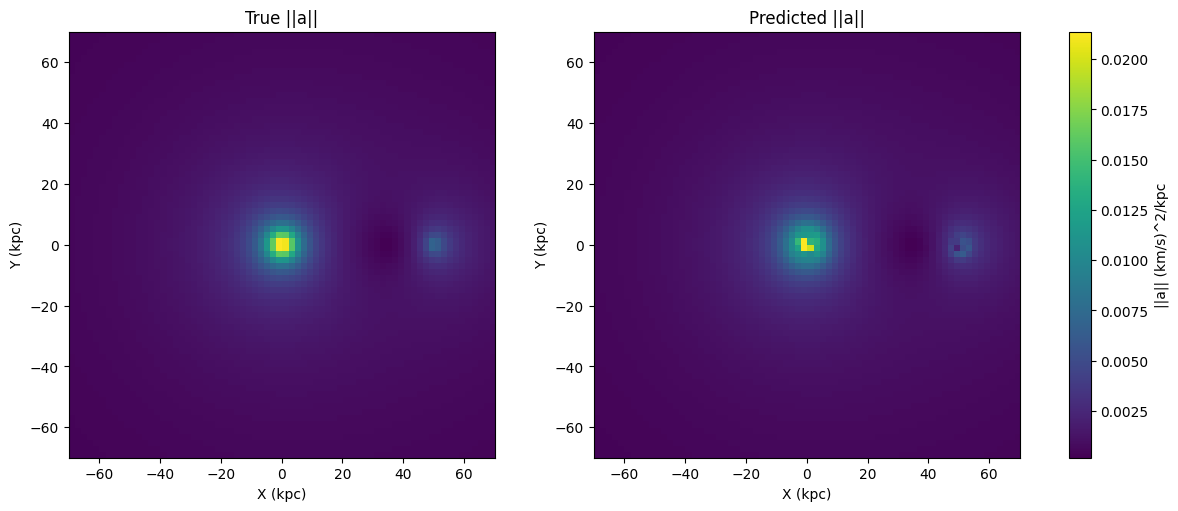

In [13]:
####
### Visualize the results
####

nx = ny = int(jnp.sqrt(len(xy_points)))
x = xy_points[:, 0].reshape((ny, nx))
y = xy_points[:, 1].reshape((ny, nx))

true_u = true_potential_xy.reshape((ny, nx))
pred_u = predicted_potential_xy.reshape((ny, nx))

true_acc_norm = true_acc_norm_xy.reshape((ny, nx))
pred_acc_norm = predicted_acc_norm_xy.reshape((ny, nx))

vmin = jnp.min(true_acc_norm)
vmax = jnp.max(true_acc_norm)

############
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

im0 = axs[0].imshow(true_acc_norm, origin="lower", extent=[x.min(), x.max(), y.min(), y.max()],
                    cmap="viridis", vmin=vmin, vmax=vmax)
axs[0].set_xlabel("X (kpc)")
axs[0].set_ylabel("Y (kpc)")
axs[0].set_title('True ||a||')


im1 = axs[1].imshow(pred_acc_norm, origin="lower", extent=[x.min(), x.max(), y.min(), y.max()],
                    cmap="viridis", vmin=vmin, vmax=vmax)
axs[1].set_title("Predicted $\phi$")
axs[1].set_xlabel("X (kpc)")
axs[1].set_ylabel("Y (kpc)")
axs[1].set_title('Predicted ||a||')
fig.colorbar(im1, ax=axs.ravel().tolist(), label='||a|| (km/s)^2/kpc')

plt.show()
